# Project at Computer Graphics: Edge Detection


In this project I will be implementing the Canny algorithm for edge detection in images for the first avaliation of the discipline Introdução a Computação Gráfica at FGV. 

In [36]:
from PIL import Image
import numpy as np
from IPython.display import display

## Abrindo a imagem e obtendo seu .data

In [271]:
%%html
<img src = "gato-caixa-areia.jpg" width = "600px"></img>

In [297]:
im = Image.open('gato-caixa-areia.jpg')
data = np.array(im.getdata())
print('Tamanho da imagem em pixels:')
print(im.width, 'x', im.height)
print('Tamanho do nosso array de pixels:')
print(data.shape)

Tamanho da imagem em pixels:
712 x 475
Tamanho do nosso array de pixels:
(338200, 3)


## Tornando a imagem em grayscale

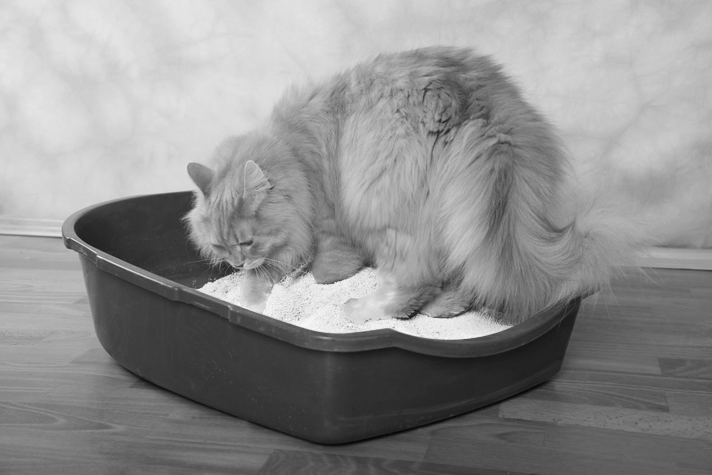

In [298]:
for i in range(len(data)):
    data[i][0] = data[i][1] = data[i][2] = int(data[i].mean())
data = data.reshape(475,712, 3).astype(np.uint8)
gray_scale = Image.fromarray(data)
display(gray_scale)

## Aplicando o filtro gaussiano

In [299]:
def gaussian_func(x,y, sigma):
    val = (np.pi*2*sigma**2)
    e = -(((x-2)**2+(y-2)**2)/(2*sigma**2))
    return np.exp(e)/val

def filtro_gaussiano(sigma, data):
    x, y = np.mgrid[0:5,0:5]
    gauss_mat = np.round(gaussian_func(x,y,1)*343)
    coef = 343
    ans = np.zeros(data.shape)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ans[i][j][0] = ans[i][j][1] = ans[i][j][2] = np.round(sum(sum(convolution(gauss_mat, data, i, j)))/coef)
    return ans

def convolution(matriz_coef, data, x, y):
    ans = np.zeros((5,5))
    for i in range(x-2,x+3):
        for j in range(y-2,y+3):
            if (0<=i<=474) and (0<=j<=711):
                ans[i+2-x][j+2-y] = matriz_coef[i+2-x][j+2-y]*data[i][j][1]
            else:
                ans[i+2-x][j+2-y] = matriz_coef[i+2-x][j+2-y]*data[x][y][1]
    return ans

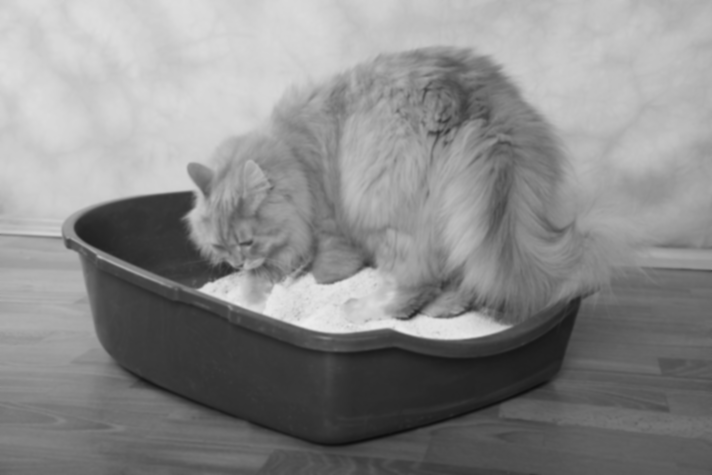

In [300]:
data1 = filtro_gaussiano(1, data)
efeito_gaussiano = Image.fromarray(data1.astype(np.uint8))
display(efeito_gaussiano)

In [275]:
#trying recursive

#def gaussian(matrix,pixel,counter=0, ans = []):
#    dic = {0:[(1,0), , 1:(1,1),2:(0,1),3:(-1,1),4:(-1,0),5:(-1,-1),6:(0,-1),7:(1,-1)}
#    if nth_neibourgh < 8:
#        evaluing = pixel+np.array(list(dic[counter]))
#        if min(evaluing) >= 0:
#            ans.append(matrix[tuple(evaluing)])
#        return gaussian(matrix,pixel,counter+1,ans)
#    else:
#        return np.mean(ans)